# Task 3 : Super-Resolution using Random Fourier Features (RFF) [4 Marks]

Demonstrate the following applications using the cropped image from the notebook:

1. Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) [3 Marks]

2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: [1 Marks]
 - RMSE on predicted v/s ground truth high resolution image
 - Peak SNR on predicted v/s ground truth high resolution image

In [12]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

%pip install torchmetrics

from utils import load_image, normalize_image, crop_image, extract_coordinates_pixels, normalize_tensor, train, create_rff_features, create_linear_model, create_coordinate_map, get_reconstructed_image, metrics, downsample_image

Tensor shape:  torch.Size([3, 1365, 2048])
Cropped image shape:  torch.Size([3, 400, 400])


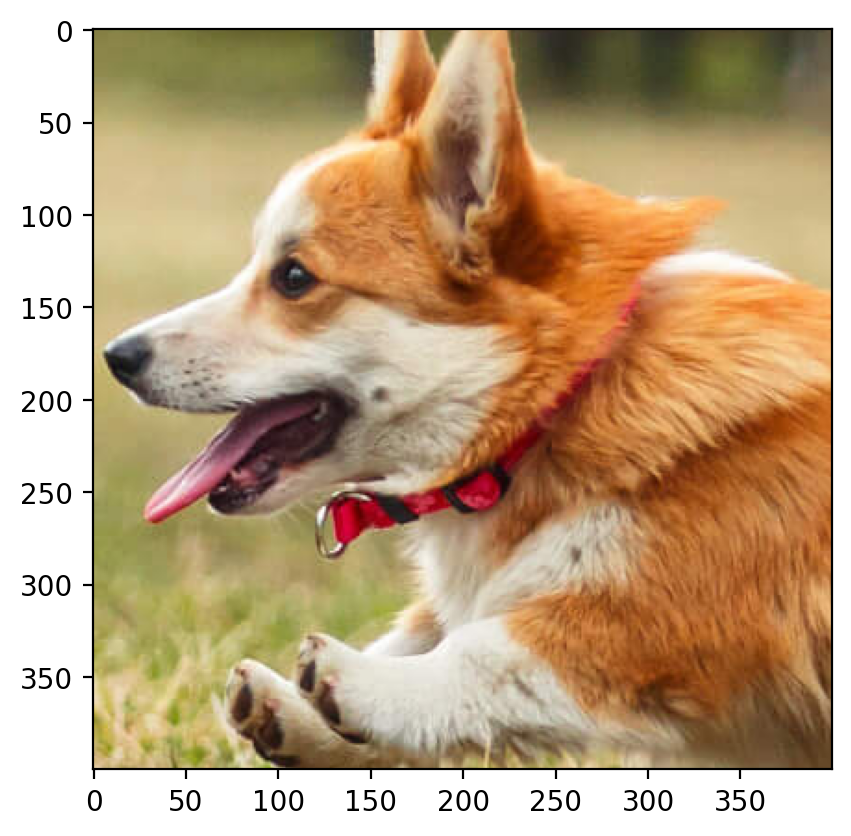

In [13]:
image_path = "images/dog.jpg"
image = load_image(image_path)

normalized_image = normalize_image(image) # 0.0 to 1.0
cropped_image = crop_image(normalized_image, 400, 550, 800)

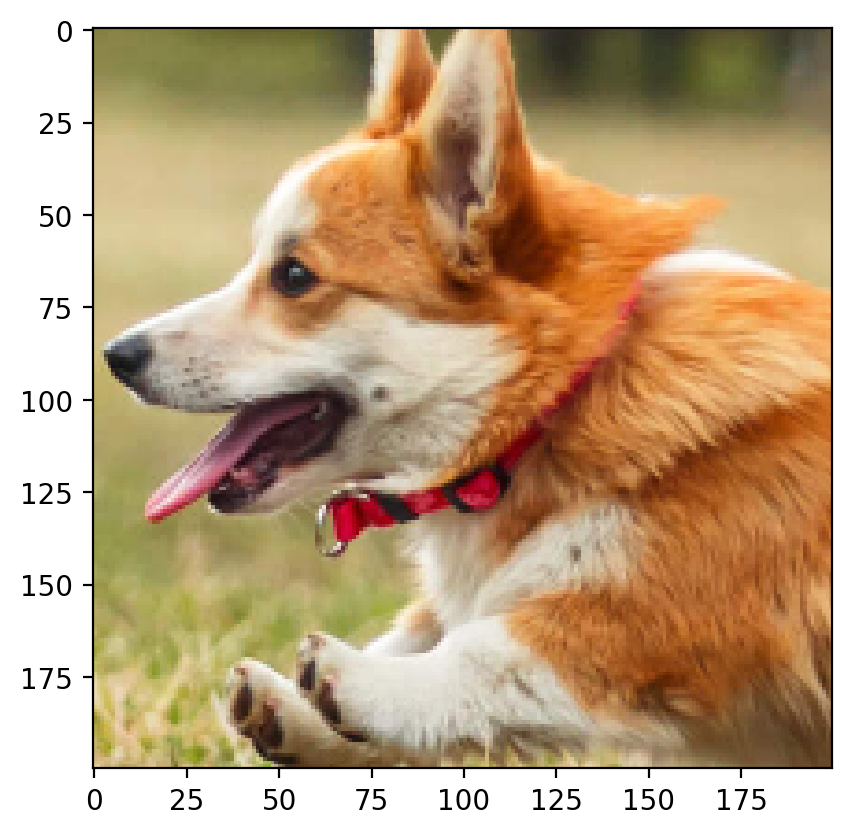

In [14]:
low_res_image = downsample_image(cropped_image, scale=2, device=device)

In [15]:
coords, pixels = extract_coordinates_pixels(low_res_image, device=device)

Coordinates shape:  torch.Size([40000, 2])
Pixel values shape:  torch.Size([40000, 3])


In [16]:
coords.max(), coords.min()

(tensor(199.), tensor(0.))

In [17]:
coords = normalize_tensor(coords)

In [18]:
print(coords.min(), coords.max())

tensor(-1.) tensor(1.)


In [19]:
def plot_reconstructed_and_original_image(original_image, model, coords, flag, title=""):
    # if the flag is 1 then the image is the original one, if the flag is 2 then the image is the downsampled one
    num_channels, height, width = original_image.shape
    model.eval()  # set the model to evaluation mode which disables dropout and batch normalization
    with torch.no_grad():  # disable gradient calculation as we don't need it for visualizing to speed it the process
        outputs = model(coords)
        # apply sigmoid activation
        # outputs = torch.sigmoid(outputs)
        # outputs = (outputs - outputs.min()) / (outputs.max() - outputs.min())
        # improve the contrast
        # outputs = torch.pow(outputs, 1.2)
        if (flag == 1):
            outputs = outputs.reshape(height, width, num_channels)
        else:
            outputs = outputs.reshape(height * 2, width * 2, num_channels)

    fig = plt.figure(figsize=(6, 4))
    # this allows us to create a flexible grid layout for plotting multiple subplots
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    ax1.imshow(original_image.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [20]:
# parameters are coordinates, number of features, and sigma
image_rff = create_rff_features(coords, 200000, 0.01, device=device)

In [21]:
model = create_linear_model(image_rff.shape[1], 3, device=device)
model.to(device)

train(image_rff, pixels, model, learning_rate=0.01,
      epochs=1000, threshold=1e-9, verbose=True)

Epoch 0 loss: 0.343616
Epoch 100 loss: 0.000379
Epoch 200 loss: 0.000079
Epoch 300 loss: 0.000075
Epoch 400 loss: 0.000073
Epoch 500 loss: 0.000072
Epoch 600 loss: 0.000071
Epoch 700 loss: 0.000071
Epoch 800 loss: 0.000070
Epoch 900 loss: 0.000070


6.94158225087449e-05

In [22]:
coords_new = create_coordinate_map(400, 400, device=device, inv=True) # create the coordinate map for the new image
coords_new = normalize_tensor(coords_new)

In [23]:
image_rff_new = create_rff_features(coords_new, 200000, 0.01, device=device) # create the RFF features for the new image

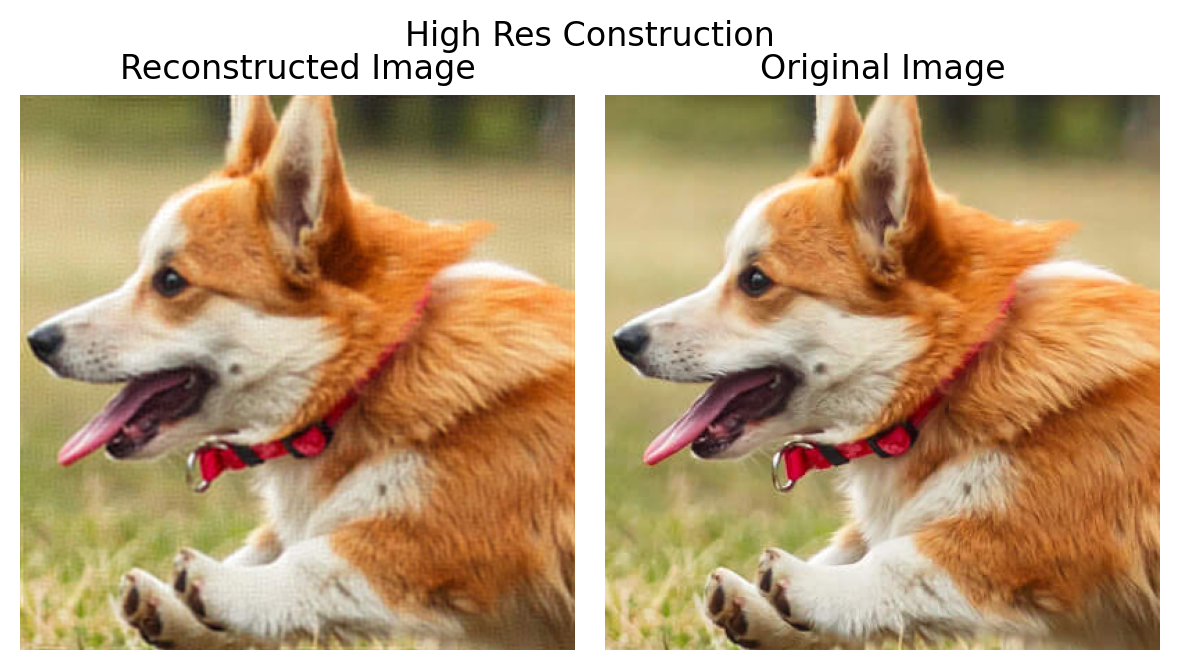

In [24]:
plot_reconstructed_and_original_image(cropped_image, model, image_rff_new, title="High Res Construction", flag = 1)

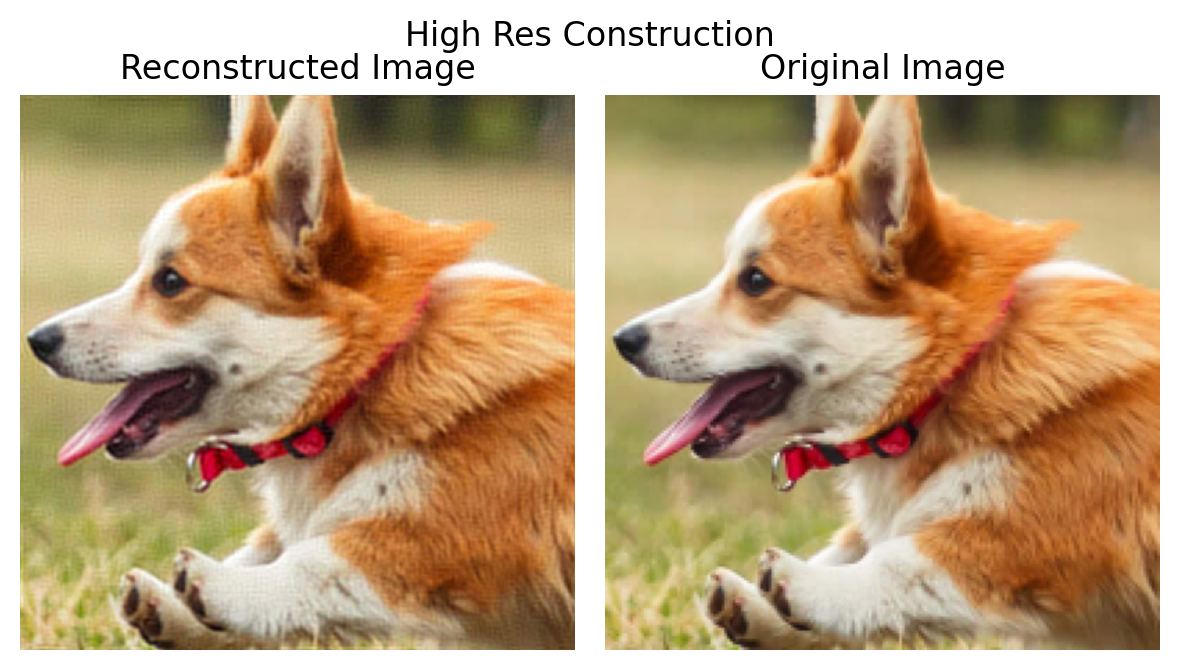

In [25]:
plot_reconstructed_and_original_image(low_res_image, model, image_rff_new, title="High Res Construction", flag = 0)

In [26]:
reconstructed_image = get_reconstructed_image(model, coords_new, image_rff_new, 400, 400)
reconstructed_image = rearrange(reconstructed_image, 'c h w -> w h c').cpu() # rearrange the image tensor to make it compatible with the below code

In [27]:
reconstructed_image.shape, cropped_image.shape

(torch.Size([3, 400, 400]), torch.Size([3, 400, 400]))

In [28]:
print(cropped_image.shape)
print(reconstructed_image.shape)

torch.Size([3, 400, 400])
torch.Size([3, 400, 400])


In [29]:
rmse, psnr = metrics(cropped_image.transpose(1, 2).reshape(-1, 1), reconstructed_image.reshape(-1, 1))
print("RMSE: ", rmse)
print("PSNR: ", psnr)

RMSE:  tensor(0.0220)
PSNR:  tensor(33.1332)
